### RegNet

### Designing Network Design Spaces (Ilija Radosavovic et al., 2020, (FAIR))

[Paper](https://arxiv.org/abs/2003.13678)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Fbeta, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers.tqdm_logger import ProgressBar

import matplotlib.pyplot as plt
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

assert torch.cuda.is_available() is True
%load_ext watermark

* Concepts evolution:


<img src="../assets/1_regnet.png" width="850">

* The article suggest new network design paradigm that combines the advantages of manual design and NAS.


* Despite the effectiveness of NAS, the paradigm has limitations. The outcome of the search is a single network instance tuned to a specific setting (e.g., hardware platform).


* Moving from NAS: sampling models from a design space, giving rise to a model distribution, and turn to tools from classical statistics to analyze the design space. This differs from architecture search, where the goal is to find the single best model from the space.


* How to assess models spaces: sampling a set of models from that design space and characterizing the resulting model error distribution. The key intuition behind this approach is that comparing distributions is more robust and informative than using search (manual or automated) and comparing the best found models from two design spaces. 


* Key features:

    * Generate distributions of models obtained by sampling and training n models from a design space.
    * Regime: low-compute, low-epoch: 400MF(million flops), 10 epochs,  ImageNet dataset.
    * Compute and plot error EDFs (empirical distribution functions) to summarize design space quality:
    
$$F(e) = \frac{1}{n}\sum_{i=1}^n\mathbb{1}[e_i \le e],$$

$F(e)-$ the fraction of models with error less than $e$.

* 

   * Visualize various properties of a design space and use an empirical bootstrap to gain insight.
   * Use gained insights to refine the design space.
    









* AnyNet (stem + network body + network head) -> RegNet models space
* RegNets: RegNetX, RegnetY (RegNetX + Squeeze-and-Excitation operation)

#### Squeeze-and-Excitation block


With the squeeze-and-excitation block, the neural nets are better able to map the channel dependency along with access to global information. Therefore, they are better able to recalibrate the filter outputs and thus, this leads to performance gains.

In [2]:
class SqExBlock(nn.Module):
    def __init__(self, c: int, r: int = 16):
        super(SqExBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True), # Main nonlinearity
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()           # Smoothing values
        )

    def forward(self, x):
        # Basically, in torch we have (b, c, w, h) dims order
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        # Weighting
        z = x * y.expand_as(x)
        return z

#### Torch [implementation](https://github.com/pytorch/vision/blob/93104c1697384273a75381d57be2f872265eeefb/torchvision/models/regnet.py#L296)

In [3]:
[x for x in dir(torchvision.models) if 'regnet' in x]

['regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf']

In [4]:
regnet_y = torchvision.models.regnet_y_400mf(pretrained=True, progress=False)

#### CIFAR10 with pytorch ignite

In [5]:
imagenet_norm = {'mean':(0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}
val_start = 45000
batch_size = 128
store_data = './data'
device = 'cuda:0'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(**imagenet_norm)])

trainset = datasets.CIFAR10(store_data, download=True, train=True, transform=transform)
trainset.targets = trainset.targets[:val_start]
trainset.data = trainset.data[:val_start]

valset = datasets.CIFAR10(store_data, download=False, train=True, transform=transform)
valset.targets = valset.targets[val_start:]
valset.data = valset.data[val_start:]

testset = datasets.CIFAR10(store_data, download=True, train=False, transform=transform)


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size)
test_loader = DataLoader(testset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


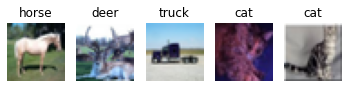

In [6]:
n_imgs = 5
fig, axs = plt.subplots(1, n_imgs)
for i, idx in enumerate(np.random.randint(size=n_imgs, low=0, high=trainset.data.shape[0]-1)):
    axs[i].imshow(trainset.data[idx])
    axs[i].axis('off')
    axs[i].set_title(trainset.classes[trainset.targets[idx]])
plt.show()

In [7]:
(len(trainset.targets), len(valset.targets), len(testset.targets))

(45000, 5000, 10000)

In [8]:
(trainset.data.shape, valset.data.shape, testset.data.shape)

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
regnet_y.fc = nn.Linear(in_features=regnet_y.fc.in_features, out_features=len(trainset.classes))
regnet_y.to('cuda')

optimizer = torch.optim.Adam(regnet_y.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
epochs = 5
trainer = create_supervised_trainer(regnet_y, optimizer, criterion, device=device)
metrics = {
    'f1': Fbeta(beta=1),
    'ce':Loss(criterion),
}
train_evaluator = create_supervised_evaluator(regnet_y, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(regnet_y, metrics=metrics, device=device)

training_history = {'loss':[], 'f1': []}
validation_history = {'loss':[], 'f1': []}
last_epoch = []

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [12]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    f1 = metrics['f1']
    loss = metrics['ce']
    last_epoch.append(0)
    training_history['f1'].append(f1)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg F1: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, f1, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    f1 = metrics['f1']
    loss = metrics['ce']
    validation_history['f1'].append(f1)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg F1: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, f1, loss))

In [13]:
get_last_val_score = lambda x: validation_history['f1'][-1]
get_last_epoch = lambda eng, last_state: eng.state.epoch
checkpointer = ModelCheckpoint('./saved_models', 'regnety', 
                               global_step_transform=get_last_epoch,
                               score_function=get_last_val_score,
                               create_dir=True, 
                               require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'cifar10': regnet_y})

ignite_pbar = ProgressBar()
ignite_pbar.attach(trainer)

In [ ]:
trainer.run(train_loader, max_epochs=epochs)

In [14]:
def fetch_last_checkpoint(model_save_path, name):
    checkpoint_files = (x for x in os.listdir(model_save_path) if name in x)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

regnet_y.load_state_dict(torch.load(fetch_last_checkpoint('./saved_models', 'regnety_cifar10')))

<All keys matched successfully>

In [15]:
test_evaluator = create_supervised_evaluator(regnet_y, metrics=metrics, device=device)
regnet_y.eval()
ProgressBar().attach(test_evaluator)
test_evaluator.run(test_loader)
test_evaluator.state.metrics

[1/79]   1%|1          [00:00<?]

{'f1': 0.8108778604226827, 'ce': 0.6002994140625}

#### References

* https://onnx.ai/
* https://pytorch.org/docs/stable/index.html
* https://github.com/facebookresearch/pycls
* https://amaarora.github.io/2020/07/24/SeNet.html